# Building a complete Application

## Goals

* Explore the libraries of kernels available in this software framework

* Learn about kernel metadata

* Construct your first NPU graph using Riallto Python APIs

* Run the application you built on your Ryzen AI NPU

## References

**[Multi-Level IR Compiler Framework (MLIR)](https://mlir.llvm.org/)**

**[MLIR-AIE](https://github.com/Xilinx/mlir-aie)** 

---

## Library of Optimized Kernels

A library of optimized example kernels is available at `npu.lib`. Run the following cell to find out which kernels are available:

In [1]:
from npu.utils import aiekernels

aiekernels()

['AddWeighted',
 'AddWeightedScalar',
 'BitwiseAnd',
 'BitwiseAndScalar',
 'BitwiseOr',
 'BitwiseOrScalar',
 'Filter2d',
 'Filter2dScalar',
 'Gray2Rgba',
 'Gray2RgbaScalar',
 'Inverse',
 'Median',
 'MedianScalar',
 'Plus1',
 'PlusN',
 'Rgba2Gray',
 'Rgba2GrayScalar',
 'Rgba2Hue',
 'Rgba2HueScalar',
 'RgbaInverse',
 'RgbaRtpThres',
 'ThresholdGrayscale',
 'ThresholdRgba']

* `AddWeighted`
    * vectorized implementation of [cv2.addWeighted()](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19) 
* `BitwiseAnd`
    * vectorized implementation of [cv2.bitwise_and()](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14) 
* `BitwiseOr`
    * vectorized implementation of [cv2.bitwise_and()](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gab85523db362a4e26ff0c703793a719b4)
* `Gray2Rgba`
    * vectorized implementation of [cv2.cvtColor(..., cv.CV_GRAY2RGBA)](https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)
* `Inverse`
    * vectorized implementation of creating the negative of a grayscale image
* `Rgba2Gray`
    * vectorized implementation of [cv2.cvtColor(..., cv.CV_RGBA2GRAY)](https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)
* `RgbaInverse`
    * vectorized implementation of creating the negative of an RGBA image
* `Rgba2Hue`
    * vectorized implementation of [cv2.cvtColor(..., cv.CV_RGBA2HSV)](https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)
* `RgbaRtpThres`
    * vectorized implementation of [cv2.threshold(...)](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) only for binary threshold
* `ThresholdGrayscale`
    * vectorized implementation of [cv2.threshold(...)](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)
* `ThresholdRgba`
    * vectorized implementation of [cv2.threshold(...)](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) for an RGBA image
* `Filter2d`
    * vectorized implementation of [cv2.filter2D(...)](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

You will also see that some kernels have a scalar implementation.

Run the following cell to check the vectorized code of one the kernel `RgbaRtpThres`:

In [2]:
import npu

threshold = npu.lib.RgbaRtpThres()
print(threshold.srccode)

// Copyright 2023 Advanced Micro Devices, Inc.
// SPDX-License-Identifier: MIT

#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <aie_api/aie.hpp>

extern "C" {

void rgba_rtp_thresh(uint8_t *in_buffer, uint8_t* out_buffer, uint32_t nbytes, uint8_t r_thresh, uint8_t g_thresh, uint8_t b_thresh) {
    uint8_t pixel_rtps[4];
    pixel_rtps[0] = r_thresh; 
    pixel_rtps[1] = g_thresh; 
    pixel_rtps[2] = b_thresh; 
    pixel_rtps[3] = 0; 

    ::aie::vector<uint8_t, 64> t_vec = ::aie::broadcast<uint32_t, 16>(*(uint32_t*)pixel_rtps).cast_to<uint8_t>();
    auto sat_vec = ::aie::broadcast<uint8_t, 64>(255);
    auto zero_vec = ::aie::zeros<uint8_t, 64>();

    uint16_t loop_count = (nbytes) >> 6;
    for(int j=0; j< loop_count; j++){
        auto i_buf = ::aie::load_v<64>(in_buffer);
        auto lt_mask = ::aie::lt(i_buf, t_vec);
        auto o_buf = ::aie::select(zero_vec, sat_vec, lt_mask);
        ::aie::store_v(out_buffer, o_buf);

        in_buffer += 64;
        o

Let us examine the kernel metadata. Execute the following cell to display the metadata for the kernel that we just defined:

In [ ]:
threshold.metadata

### Interpreting the metadata

At the top level of this metadata, we should see the following fields:
* **rgba_rtp_thresh**: the root of our metadata tree
    * **name**
        * a unique name for this kernel instance, for example, `rgba_rtp_thresh_0`
    * **tloc**
        * tile location: the location on the array this tile is mapped to
    * **ttype**
        * tile type: the type of tile in the array into which the kernel must be placed.  In this case, this will become compute tile (CT) later
    * **buffers**
        * a set of buffers for this kernel
    * **parameters**
        * a set of parameters for this kernel
    

We have two sets **buffers**, and **parameters** in our kernel metadata. The general rule is that any kernel function argument of type pointer, such as `uint8_t *` is interpreted as a pointer to a buffer.  Any argument with a non-pointer type, such as `uint32_t` is classified as a "regular" parameter. 

You may have noticed that the **tloc** field says `null`. It is `null` because this kernel has not yet been assigned to a compute tile in the array. The most common way for a kernel to get a location is to use it within an `AppBuilder` class. The `AppBuilder` will then place the kernel on a tile assigning this metadata. 

Alternatively, a user can specify a location up front.  Then when the kernel gets used with the `AppBuilder`, the location becomes a constraint for that kernel. We will explore explicitly setting the **tloc** of a kernel later.

#### Exploring metadata for input and output buffers

In our `threshold` kernel code, we pass two pointers, `in_buffer` and `out_buffer`.  If we expand the **buffers** item in the metadata, we can see the corresponding entries for `in_buffer` and `out_buffer`.  Expanding the buffer items, reveals the following fields for each buffer:

* **c_dtype**
    * the data type in the C++ kernel code for this buffer
* **direction**
    * the direction of the buffer. If data is pushed into this buffer, it is an input.  When the kernel writes data into the buffer, which will be pulled when the kernel completes, it is an output.
* **shape**
    * the shape of this buffer, in the [numpy shape format](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html). This defines the dimensions of the array. 
* **dtype**
    * the dtype of this buffer, in the [numpy dtype format](https://numpy.org/doc/stable/reference/generated/numpy.dtype.html). The *dtype* describes how the bytes in a memory block should be interpreted.

The `c_dtype` is how the c application views the memory buffer. The `dtype` is how the data is represented in Python. These views could be the similar, for example, the `uint8_t` C type is similar to the uint8 Python type. Alternatively, the types can be different. For example, the Python dtype could be `uint32` viewing grouping 4x 8-bit values together if this is more convenient for the Python application. The standard C and Python rules apply if you need to cast these types within your C code or Python code. 

You may have noticed that the direction, shape, and dtype fields all null for every buffer.
To understand why, we are going to have to look at our __AppBuilder__ class. 

---


## Create your First Callgraph

In the previous examples we used a pre-defined graph template which defined the data movement for our applications. This allowed us to focus on the software kernels. As a reminder, the `RGB720PBuilder` is designed to handle 720p RGBA images and it uses a single interface tile and a single compute tile. We will look next at how to create a `callgraph` that replicates the functionality of `RGB720PBuilder` using the Riallto Python APIs.

We are going to start simple and rebuild the two graph templates that we used in the previous notebook examples, consisting of one interface tile connected directly to a single compute tile. 

Start by making a new Python class `SimpleApplication` that inherits from the `AppBuilder` class.

In [4]:
import numpy as np

from npu.build.appbuilder import AppBuilder


class SimpleApplication(AppBuilder):

    def __init__(self):
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        pass

`SimpleApplication` has two methods:

* `__init__`
    * which calls the `AppBuilder` initialization method
* `callgraph`
    * where we will specify how data flows thought the kernels

Notice how the `callgraph` method has two input parameters called `x_in` and `x_out`. These parameters are our application's external inputs and outputs.  We use them to exchange data between the Python code running on the x86 host and the application running on the NPU. 

`x_in` and `x_out` are declared as `numpy` arrays which have dimension and shape.  In the `callgraph` method, apart from defining the data movement between kernels, we can index and slice these arrays to partition the data into chunks that will be sequenced through our application.

To mimic `RGB720pBuilder`, we define `x_in` for our input image and `x_out` for our output image. Other applications can have more buffers. 

Currently, the callgraph is empty. We will now proceed to populate it to replicate the functionality of `RGB720pBuilder`.

<div class="alert alert-info" role="info">

The `callgraph` method currently supports up to two input numpy arrays and up to two output numpy arrays.

</div>

### Create an instance of `SimpleApplication`

In [5]:
app_builder = SimpleApplication()

### Tracing our application to schedule data flow

The `callgraph` is where the user specifies, at a high level, the arrangement of kernels and defines the data flowing through them. The `callgraph` generates an abstract internal representation of our design, which is then transformed into code and compiled into something that can be used to configure the NPU. The final outputs are the application binaries we can use to configure and run the application on the NPU.

### Riallto build flow

The diagram below shows an overview of the Riallto build flow:

<center><img src="./images/png/rough_toolflow.png" style="max-height: 900px; width:auto; height:auto;"></center>
<center><strong>Riallto compilation flow</strong></center>

1. The `callgraph` and input and output `numpy` arrays are fed into the application tracer. This application tracer then runs the `callgraph` against the input and output `numpy` arrays, tracking how the arrays are partitioned. It also follows how data flows through the kernels and how the shape of the data is transformed as it passes through each kernel. Each kernel has an optional behavioral model that is executed while the `callgraph` is running, allowing for a behavioral simulation of the design.
2. Once the `callgraph` has returned, it produces an internal abstract representation of how kernels are connected and the data schedule as it flows through these kernels and connections.
3. At this stage, it is possible to introspect the design. The metadata of this abstract representation can be inspected to see how the kernels are placed, how they are connected, and how data flows through the design. It is also possible to visualize the application and how it is placed on a column of the array.
4. The *codegen* stage takes the abstract representation for the application graph and transforms it into MLIR-AIE for compilation. [Multi-Level IR Compiler Framework (MLIR)](https://mlir.llvm.org/) is a very popular project for *building reusable and extensible compiler infrastructure*. [MLIR-AIE](https://github.com/Xilinx/mlir-aie) is a software toolchain that generates MLIR *Intermediate Code* that describes the NPU configuration and data movement for the application. If you are interested, you can view this intermediate code, but you do not need to use it directly or understand the generated code. You will only need to use the Riallto Python APIs to generate a callgraph, and C++ code to write software kernels. 
5. The last step is to compile the code for the software kernel(s) and the graph to generate the application binaries. We say binaries (plural) as each AI Engine used in the NPU will have a separate binary, along with the graph for the NPU. All of the binaries will be included in a single binary container file the XCLBIN (.xclbin file extension).

### Trace the `callgraph`

Use app_builder to trace the callgraph

In [6]:
import numpy as np

x_in = np.zeros(shape=(720,1280,4), dtype=np.uint8)
x_out = np.zeros(shape=(720,1280,4), dtype=np.uint8)
app_builder(x_in, x_out)

<div class="alert alert-info" role="info">

Now we have a stub for our application class with an empty `callgraph`.

</div>

### Instantiate the kernel

Now we will extend our `SimpleApplication` class so that it can be initialized with a kernel object. Notice that the kernel will be passed to the `SimpleApplication` class when an instance is created. 

In [7]:
from npu.build.kernel import Kernel

class SimpleApplication(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        pass

With our kernel included we are ready to define our `callgraph`. 


### Add a loop to the callgraph

In our example application from the previous notebooks, we were passing in a row of a 720p image each kernel call. This means that we want to iterate over each row of the input image. 

We will create a `for loop` to iterate over the rows of our input image:

In [8]:
class SimpleApplication(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        rows = x_in.shape[0]
        for row in range(rows):
            pass

The following code is used to iterate over the number of rows in the input image:

```python
        rows = x_in.shape[0]
        for row in range(rows): 
```

Note that: `x_in.shape` returns (720, 1280, 4) so that `x_in.shape[0]` returns 720 which is the number of rows.  
We will shortly use `x_in.shape[1] * x_in.shape[2]`, which returns 1,280 x 4 and is the number of bytes per row.


### Add the kernel call

Next, we need to slice the input image along those rows, call the kernel, and pass that data into the kernel.

Let us add the kernel call. We will be passing the threshold kernel from the Riallto library of optimized kernels, so the parameters for the kernel call need to match the threshold function prototype:

```c++
void rgba_rtp_thresh(uint8_t *in_buffer, uint8_t* out_buffer, uint32_t nbytes, uint8_t r_thresh, uint8_t g_thresh, uint8_t b_thresh)
```

We need to pass the input and output buffers, the number of bytes in each row, and the threshold value for each channel. `x_in.shape[1]*x_in.shape[2]` is equal to 1280*4 and the threshold values are 128. 

In [9]:
class SimpleApplication(AppBuilder):

    def __init__(self, kernel: Kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            kernel_output = self.kernel(x_in[row], bytes_per_row, 128, 128, 128)

### Visualize the application

We can declare an instance of SimpleApplication, passing it the threshold kernel.  

In [10]:
app_builder = SimpleApplication(kernel=threshold)
app_builder(x_in, x_out)

The current state of the application can now be visualized. 

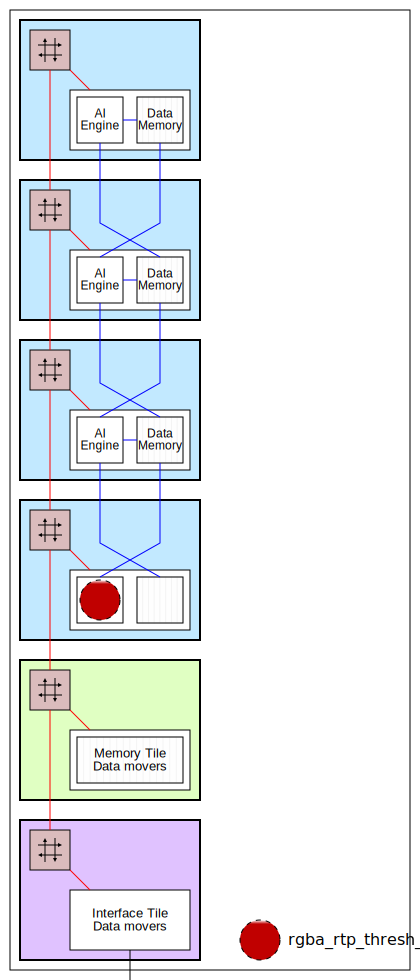

In [11]:
app_builder.display()

#### Compute tile locations and the `tloc` parameter 

In the visualization above we can see that the kernel `rgba_rtp_thresh_0` has been mapped to the first compute tile at the bottom of the column. 

We can also verify this in the metadata. Expand **SimpleApplication > kernels > rgba_rtp_thresh_0 > tloc**

In [ ]:
app_builder.metadata

The compute tile has been placed at location `(0,2)` in the array, where the first index is the relative column index and the second is the row. Each tile has a row number. The interface tile in this column is `(0,0)`, the memory tile is `(0,1)` and the compute tiles start at `(0,2)`. 

### Specify the location for a compute tile

We can also constrain where we would like to place our kernel in the column by manually setting the tile location parameter, `tloc`, for that kernel.  Try running the cell below to move the kernel to a different location and visualize the result:

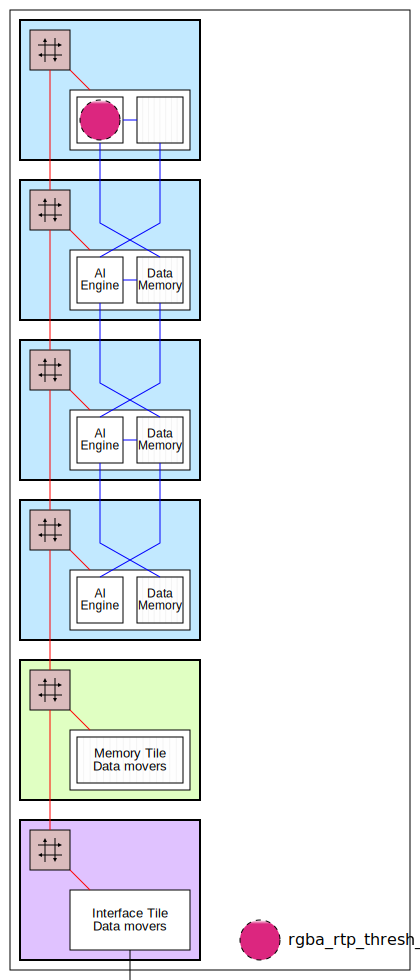

In [13]:
threshold.tloc = (0,5)

app_builder = SimpleApplication(kernel=threshold)
app_builder(x_in, x_out)
app_builder.display()

We can see that the kernel above has moved to the top compute tile. Try moving changing the threshold kernel placement yourself. 

<div class="alert alert-warning" role="warning">

The first value in the `tloc` tuple is the column offset.  Our application uses a single column so this will always be 0.

</div>

#### Write the output

The last step is to get the result from the NPU application and write it back to output buffer we declared earlier in external memory. To do this we need to use the *interface tile*. The compute tile where the software kernel is running does not have direct access to external system memory. 

The `kernel_output` is passed to the `x_out[t]`. This is equivalent to an `ITWrite()` (Interface Tile write).


In [14]:
class SimpleApplication(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            kernel_output = self.kernel(x_in[row], bytes_per_row, 128, 128, 128)
            x_out[row] = kernel_output

The application is now complete. We can now visualize the final application. 

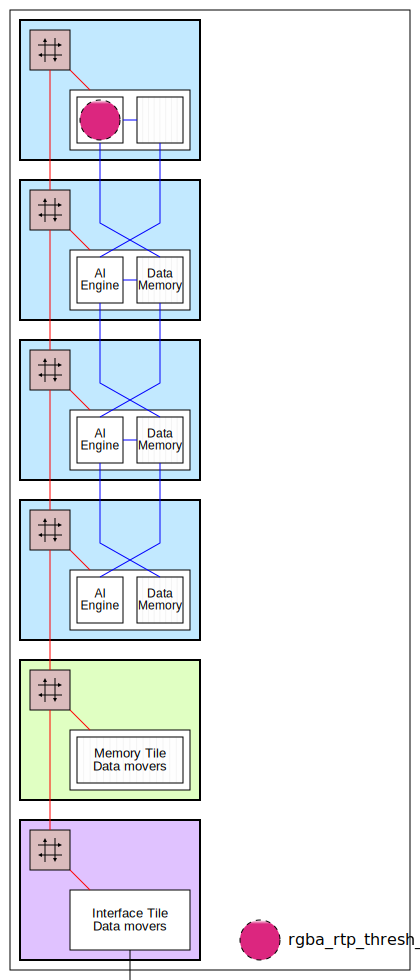

In [15]:
x_in = np.zeros(shape=(720, 1280,4), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280,4), dtype=np.uint8)

app_builder = SimpleApplication(kernel=threshold)
app_builder(x_in, x_out)

app_builder.display()

The pink and light pink tokens in the diagram represent the flow of data into and out of our threshold kernel.

### Build and test the application

First, build the application. Notice we pass the Python input and output buffers to the `build()` method.

In [16]:
app_builder.build(x_in, x_out)

Using cached rgba_rtp_thresh kernel object file...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered



---


#### Run the application

Now that the application has been built, run it to make sure that the output is as expected.

#### 1. Get an input image

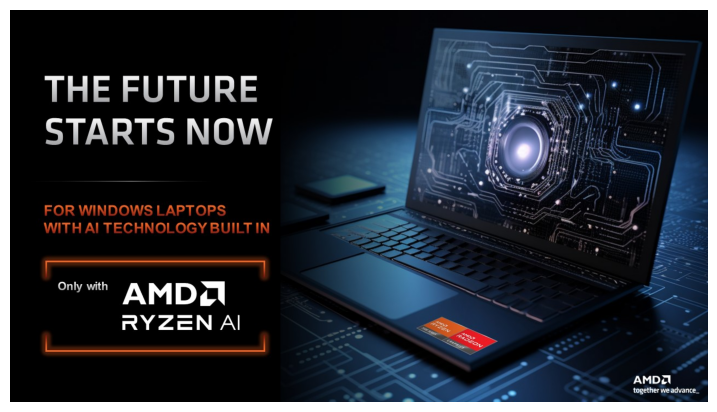

In [17]:
from npu.utils import OpenCVImageReader, image_plot

img = OpenCVImageReader('images/jpg/ryzenai_future_starts_now.jpg').img
image_plot(img)

#### 2. Call the NPU device

In [18]:
from npu.runtime import AppRunner

app = AppRunner('SimpleApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)
output_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)

# Load RGBA 720p image into input_image buffer
input_image[:] = img
# Pass input_image buffer to NPU
input_image.sync_to_npu()

# Run app on NPU
app.call(input_image, output_image)

# Get results from NPU via output_image buffer
output_image.sync_from_npu()

#### 3. Show the output image

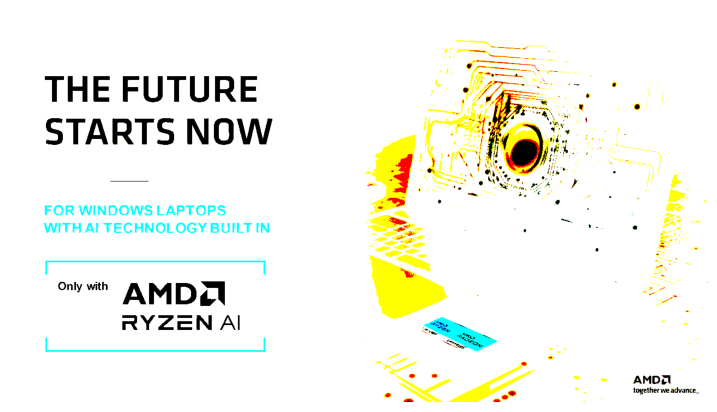

In [19]:
image_plot(output_image)

#### 4. Cleanup

In [ ]:
del app


---


## Exercise for the Reader:

Build your own application by using `RgbaInverse()` kernel provided in the Riallto library.

### Define your application

Import the necessary components and define your `callgraph`.

In [ ]:
from npu.build.appbuilder import AppBuilder
from npu.build.kernel import Kernel
import numpy as np

class SimpleApplicationExercise(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.inverse = kernel
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            kernel_output = <YOUR CODE GOES HERE> # call the RgbaInverse() kernel
            x_out[row] = kernel_output

Define input and output buffers, visualize and build your application.

In [ ]:
from npu.lib import ... # Import the RgbaInverse

x_in = np.zeros(shape=(720, 1280,4), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280,4), dtype=np.uint8)

inverse = ... # instantiate the RgbaInverse
app_builder = SimpleApplicationExercise(kernel=inverse)
app_builder(x_in, x_out)

app_builder.display()

In [ ]:
app_builder.build(x_in, x_out)

### Run your custom application

Once built, load your custom application in the NPU, run it and show the results.

In [ ]:
from npu.utils import OpenCVImageReader, image_plot
from npu.runtime import AppRunner

app = AppRunner('SimpleApplicationExercise.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)
output_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)

# Load RGBA 720p image into input_image buffer
img = OpenCVImageReader('images/jpg/ryzenai_future_starts_now.jpg').img
input_image[:] = img
# Pass input_image buffer to NPU
input_image.sync_to_npu()

# Run app on NPU
app.call(input_image, output_image)

# Get results from NPU via output_image buffer
output_image.sync_from_npu()

# Plot source and result image
image_plot(input_image, output_image)

Do not forget to clean up the application.

In [ ]:
del app


---


## Next Steps

In the next notebook you explore how to build a scaled version of the color threshold application by using the memory tile.


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>